In [1]:
import pandas as pd

In [2]:
# Load the lag analysis data
lag_analysis_cal = pd.read_csv('../data/features/q_buffer2_pair_lag.csv')
lag_analysis_cal.head()
# Run the watershed correlation analysis with inset maps
# run_watershed_correlation_analysis()

,well_id,date,wte,gse,gage_id,well_lat,well_lon,gage_lat,gage_lon,wte_meters,q,bfd,delta_wte,delta_q,year,date_prev,delta_wte_lag1_year
0,411605111481601,1933-08-08,4830.264808,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1472.264713,16.0,1.0,-3.545192,-22.0,1933,1932-08-08,0.000000
1,411605111481601,1933-08-09,4830.250000,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1472.260200,15.0,1.0,-3.560000,-23.0,1933,1932-08-09,-0.002727
2,411605111481601,1933-08-10,4830.230000,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1472.254104,14.0,1.0,-3.580000,-24.0,1933,1932-08-10,-0.005370
3,411605111481601,1933-08-11,4830.205238,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1472.246557,12.0,1.0,-3.604762,-26.0,1933,1932-08-11,-0.007930
4,411605111481601,1933-08-12,4830.178571,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1472.238429,12.0,1.0,-3.631429,-26.0,1933,1932-08-12,-0.010409


In [3]:
no_lag = pd.read_csv('../data/features/q_buffer2_pair_delta_30m.csv')
no_lag.head()

,well_id,date,wte,gse,gage_id,well_lat,well_lon,gage_lat,gage_lon,wte_meters,q,bfd,delta_wte,delta_q
0,411605111481601,1932-08-08,4833.810000,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.345288,38.0,1.0,0.000000,0.0
1,411605111481601,1932-08-09,4833.807273,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.344457,38.0,1.0,-0.002727,0.0
2,411605111481601,1932-08-10,4833.804630,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.343651,34.0,1.0,-0.005370,-4.0
3,411605111481601,1932-08-11,4833.802070,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.342871,9.0,1.0,-0.007930,-29.0
4,411605111481601,1932-08-12,4833.799591,4840.0,10141000,41.267997,-111.805216,41.278277,-112.091887,1473.342115,9.0,1.0,-0.010409,-29.0


# no lag

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

# Function to calculate mutual information
def calculate_mutual_info(x, y, n_bins=10):
    """
    Compute mutual information between two continuous variables using discretization.
    Both x and y are expected to be 1D arrays.
    """
    # Remove NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean, y_clean = x[mask], y[mask]

    if len(x_clean) < 10:  # Require a minimum of 10 samples
        return np.nan

    # Discretize continuous variables
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    x_discrete = discretizer.fit_transform(x_clean.reshape(-1, 1)).flatten()
    y_discrete = discretizer.fit_transform(y_clean.reshape(-1, 1)).flatten()

    # Calculate mutual information
    mi = mutual_info_score(x_discrete, y_discrete)
    return mi

# Function to calculate metrics per well
def calculate_well_metrics(well_data):
    """
    Calculate MI, Pearson r, and Spearman r for a single well's data.
    """
    # Extract variables
    delta_wte = well_data['delta_wte'].values
    delta_q = well_data['delta_q'].values

    # Mutual Information
    mi = calculate_mutual_info(delta_wte, delta_q, n_bins=10)

    # Pearson Correlation
    if len(delta_wte) > 1 and np.std(delta_wte) > 0 and np.std(delta_q) > 0:
        pearson_corr, _ = pearsonr(delta_wte, delta_q)
    else:
        pearson_corr = np.nan

    # Spearman Correlation
    if len(delta_wte) > 1:
        spearman_corr, _ = spearmanr(delta_wte, delta_q)
    else:
        spearman_corr = np.nan

    return pd.Series({
        'mi_delta_wte_delta_q': mi,
        'pearson_r': pearson_corr,
        'spearman_r': spearman_corr,
        'n_records': len(well_data)  # Total number of valid data points
    })

# Filter dataset to ensure no NaNs in columns of interest
filtered_no_lag = no_lag.dropna(subset=['delta_wte', 'delta_q'])

# Compute metrics grouped by well and gage
results = (
    filtered_no_lag
    .groupby(['well_id', 'gage_id'])
    .apply(calculate_well_metrics)  # Apply metrics calculation
    .reset_index()  # Reset index for cleaner output
)

# Save and display results
results.to_csv('../data/features/well_gage_mi_analysis_no_lag.csv', index=False)
print(results.head())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:334: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_62821/1801215020.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(delta_wte, delta_q)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_62821/1801215020.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(delta_wte, delta_q)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:334: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_62821/1801215020.py:50: ConstantInputWarning: An input array is constan

           well_id   gage_id  mi_delta_wte_delta_q  pearson_r  spearman_r  \
0  394618111291501  10152000              0.095602   0.156951    0.215294   
1  394643111291401  10152000              0.102255   0.157206    0.103073   
2  394813111291901  10152000              0.061242   0.204473    0.159445   
3  400219111393701  10141000              0.067289   0.160288    0.193785   
4  400440111365401  10152000              0.106116  -0.218405   -0.208220   

   n_records  
0     3799.0  
1     3448.0  
2     9140.0  
3    11926.0  
4     5227.0  


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:334: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_62821/1801215020.py:50: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(delta_wte, delta_q)
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_62821/1801215020.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_well_metrics)  # Apply metrics calculation


# lag

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

# Load lag_analysis_cal dataset (replace path if necessary)
lag_analysis_cal = pd.read_csv('../data/features/q_buffer2_pair_lag.csv')

# Function to calculate mutual information
def calculate_mutual_info(x, y, n_bins=10):
    """
    Compute mutual information between two continuous variables using discretization.
    Both x and y are expected to be 1D arrays.
    """
    # Remove NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean, y_clean = x[mask], y[mask]

    if len(x_clean) < 10:  # Require a minimum of 10 samples
        return np.nan

    # Discretize continuous variables
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    x_discrete = discretizer.fit_transform(x_clean.reshape(-1, 1)).flatten()
    y_discrete = discretizer.fit_transform(y_clean.reshape(-1, 1)).flatten()

    # Calculate mutual information
    mi = mutual_info_score(x_discrete, y_discrete)
    return mi

# Function to calculate metrics per gage
def calculate_gage_metrics(gage_data):
    """
    Calculate MI, Pearson r, and Spearman r for a single gage's data.
    """
    # Extract variables
    delta_q = gage_data['delta_q'].values
    delta_wte_lag1_year = gage_data['delta_wte_lag1_year'].values

    # Mutual Information
    mi = calculate_mutual_info(delta_wte_lag1_year, delta_q, n_bins=10)

    # Pearson Correlation
    if len(delta_q) > 1 and np.std(delta_q) > 0 and np.std(delta_wte_lag1_year) > 0:
        pearson_corr, _ = pearsonr(delta_wte_lag1_year, delta_q)
    else:
        pearson_corr = np.nan

    # Spearman Correlation
    if len(delta_wte_lag1_year) > 1:
        spearman_corr, _ = spearmanr(delta_wte_lag1_year, delta_q)
    else:
        spearman_corr = np.nan

    return pd.Series({
        'mi_delta_wte_delta_q': mi,
        'pearson_r': pearson_corr,
        'spearman_r': spearman_corr,
        'n_records': len(gage_data)  # Total number of valid data points
    })

# Filter dataset to ensure no NaNs in columns of interest
filtered_lag_analysis_cal = lag_analysis_cal.dropna(subset=['delta_q', 'delta_wte_lag1_year'])

# Compute metrics grouped by gage and well
results = (
    filtered_lag_analysis_cal
    .groupby(['gage_id', 'well_id'])
    .apply(calculate_gage_metrics)  # Apply metrics calculation
    .reset_index()  # Reset index for cleaner output
)

# Save and display results
results.to_csv('../data/features/well_gage_mi_lag.csv', index=False)
print(results.head())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:334: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_62821/1316217789.py:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(delta_wte_lag1_year, delta_q)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:334: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_62821/1316217789.py:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, _ = spearmanr(delta_wte_lag1_year, delta_q)


    gage_id          well_id  mi_delta_wte_delta_q  pearson_r  spearman_r  \
0  10126000  410202110560201              0.226203   0.142116    0.192721   
1  10126000  411643110583401              0.151724  -0.149978   -0.038776   
2  10126000  412058111002901              0.355848  -0.409583   -0.489287   
3  10126000  412248111020301              0.111064   0.017410    0.031522   
4  10126000  413124111071601              0.086769  -0.072004   -0.077888   

   n_records  
0      682.0  
1      954.0  
2      380.0  
3      902.0  
4     1233.0  


/var/folders/fk/mzjttwrn7rn5nvcfhpgm4mrc0000gq/T/ipykernel_62821/1316217789.py:71: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_gage_metrics)  # Apply metrics calculation


In [6]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gage_id               879 non-null    int64  
 1   well_id               879 non-null    int64  
 2   mi_delta_wte_delta_q  863 non-null    float64
 3   pearson_r             871 non-null    float64
 4   spearman_r            871 non-null    float64
 5   n_records             879 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 41.3 KB


# comparison

In [8]:
lag_mi = pd.read_csv('../data/features/well_gage_mi_lag.csv')
lag_mi.head()

,gage_id,well_id,mi_delta_wte_delta_q,pearson_r,spearman_r,n_records
0,10126000,410202110560201,0.226203,0.142116,0.192721,682.0
1,10126000,411643110583401,0.151724,-0.149978,-0.038776,954.0
2,10126000,412058111002901,0.355848,-0.409583,-0.489287,380.0
3,10126000,412248111020301,0.111064,0.017410,0.031522,902.0
4,10126000,413124111071601,0.086769,-0.072004,-0.077888,1233.0


In [11]:
lag_mi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gage_id               879 non-null    int64  
 1   well_id               879 non-null    int64  
 2   mi_delta_wte_delta_q  863 non-null    float64
 3   pearson_r             871 non-null    float64
 4   spearman_r            871 non-null    float64
 5   n_records             879 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 41.3 KB


In [9]:
no_lag_mi = pd.read_csv('../data/features/well_gage_mi_no_lag.csv')
no_lag_mi.head()

,well_id,gage_id,mi_delta_wte_delta_q,pearson_r,spearman_r,n_records
0,394618111291501,10152000,0.095602,0.156951,0.215294,3799.0
1,394643111291401,10152000,0.102255,0.157206,0.103073,3448.0
2,394813111291901,10152000,0.061242,0.204473,0.159445,9140.0
3,400219111393701,10141000,0.067289,0.160288,0.193785,11926.0
4,400440111365401,10152000,0.106116,-0.218405,-0.208220,5227.0


In [10]:
no_lag_mi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   well_id               1096 non-null   int64  
 1   gage_id               1096 non-null   int64  
 2   mi_delta_wte_delta_q  1088 non-null   float64
 3   pearson_r             1089 non-null   float64
 4   spearman_r            1089 non-null   float64
 5   n_records             1096 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 51.5 KB


=== Overall Summary ===
pairs: 879
mi_lag_mean: 0.2775
mi_no_lag_mean: 0.2035
mi_lag_median: 0.1806
mi_no_lag_median: 0.1460
delta_mi_mean: 0.0810
delta_mi_median: 0.0347
pct_pairs_lag_higher: 76.2230
pct_pairs_lag_much_higher_(>0.02): 62.7986
nl_gain_lag_mean: 0.0955
nl_gain_no_lag_mean: 0.0145
delta_nl_gain_mean: 0.0838

=== By-Gage (Top 10 by delta_mi_mean) ===
    gage_id  wells  mi_lag_mean  mi_no_lag_mean  delta_mi_mean  \
5  10168000     38     0.389938        0.190316       0.199622   
1  10141000    307     0.370808        0.250546       0.121688   
4  10163000    136     0.309230        0.281213       0.051001   
0  10126000    368     0.185352        0.141354       0.050450   
3  10152000     25     0.156979        0.139506       0.017473   
2  10143500      5     0.161156        0.188045      -0.026889   

   pct_wells_lag_higher  pct_wells_lag_much_higher  nl_gain_lag_mean  \
5             71.052632                  47.368421          0.079453   
1             80.130293   

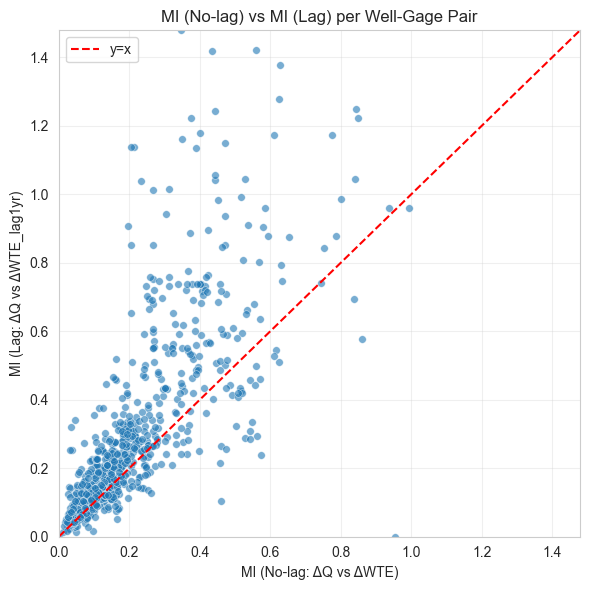

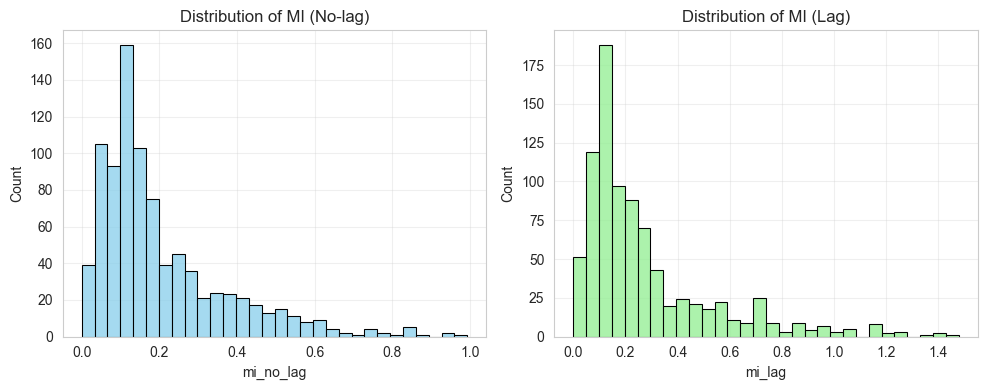

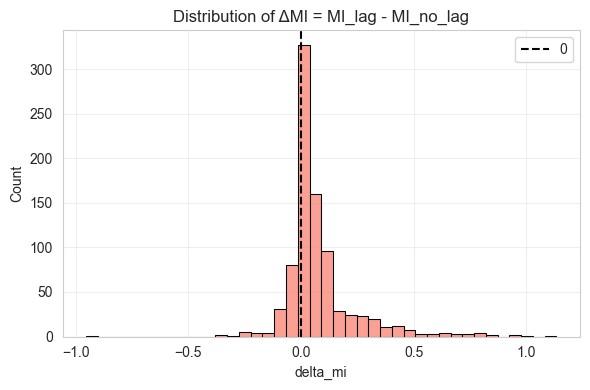

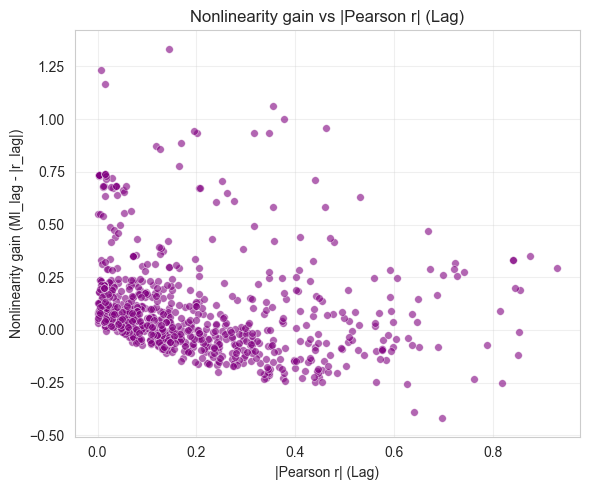

In [12]:
# Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1) 读取两类 MI 结果
lag_mi = pd.read_csv('../data/features/well_gage_mi_lag.csv')       # 来自滞后版 ΔQ vs ΔWTE_lag1_year
no_lag_mi = pd.read_csv('../data/features/well_gage_mi_no_lag.csv') # 来自同期 ΔQ vs ΔWTE

# 2) 标准化列名（确保 join 键一致）
# lag_mi: gage_id, well_id, mi_delta_wte_delta_q, pearson_r, spearman_r, n_records
# no_lag_mi: well_id, gage_id, mi_delta_wte_delta_q, pearson_r, spearman_r, n_records
lag_mi = lag_mi.rename(columns={
    'mi_delta_wte_delta_q': 'mi_lag',
    'pearson_r': 'pearson_lag',
    'spearman_r': 'spearman_lag',
    'n_records': 'n_records_lag'
})
no_lag_mi = no_lag_mi.rename(columns={
    'mi_delta_wte_delta_q': 'mi_no_lag',
    'pearson_r': 'pearson_no_lag',
    'spearman_r': 'spearman_no_lag',
    'n_records': 'n_records_no_lag'
})

# 3) 合并（井-站点对）
merged = pd.merge(
    no_lag_mi,
    lag_mi,
    on=['well_id', 'gage_id'],
    how='inner',
    validate='one_to_one'
)

# 4) 计算对比指标
eps = 1e-9
merged['delta_mi'] = merged['mi_lag'] - merged['mi_no_lag']
merged['ratio_mi'] = merged['mi_lag'] / (merged['mi_no_lag'] + eps)

# 非线性指示（相对线性皮尔逊的“提升”）
# 定义一种简易非线性指标：nl_gain = mi_lag - |pearson_lag|
merged['nl_gain_lag'] = merged['mi_lag'] - merged['pearson_lag'].abs()
merged['nl_gain_no_lag'] = merged['mi_no_lag'] - merged['pearson_no_lag'].abs()
merged['delta_nl_gain'] = merged['nl_gain_lag'] - merged['nl_gain_no_lag']

# 5) 全局汇总
summary = {
    'pairs': len(merged),
    'mi_lag_mean': merged['mi_lag'].mean(),
    'mi_no_lag_mean': merged['mi_no_lag'].mean(),
    'mi_lag_median': merged['mi_lag'].median(),
    'mi_no_lag_median': merged['mi_no_lag'].median(),
    'delta_mi_mean': merged['delta_mi'].mean(),
    'delta_mi_median': merged['delta_mi'].median(),
    'pct_pairs_lag_higher': (merged['delta_mi'] > 0).mean() * 100,
    'pct_pairs_lag_much_higher_(>0.02)': (merged['delta_mi'] > 0.02).mean() * 100,
    'nl_gain_lag_mean': merged['nl_gain_lag'].mean(),
    'nl_gain_no_lag_mean': merged['nl_gain_no_lag'].mean(),
    'delta_nl_gain_mean': merged['delta_nl_gain'].mean()
}
print("=== Overall Summary ===")
for k, v in summary.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# 6) 按 gage 聚合：统计“滞后更好”的比例
by_gage = merged.groupby('gage_id').agg(
    wells=('well_id', 'count'),
    mi_lag_mean=('mi_lag', 'mean'),
    mi_no_lag_mean=('mi_no_lag', 'mean'),
    delta_mi_mean=('delta_mi', 'mean'),
    pct_wells_lag_higher=('delta_mi', lambda x: (x > 0).mean() * 100),
    pct_wells_lag_much_higher=('delta_mi', lambda x: (x > 0.02).mean() * 100),
    nl_gain_lag_mean=('nl_gain_lag','mean'),
    nl_gain_no_lag_mean=('nl_gain_no_lag','mean'),
    delta_nl_gain_mean=('delta_nl_gain','mean')
).reset_index().sort_values('delta_mi_mean', ascending=False)

print("\n=== By-Gage (Top 10 by delta_mi_mean) ===")
print(by_gage.head(10))

# 7) 找出“滞后显著优于同期”的井（可调整阈值）
significant_improved = merged[
    (merged['delta_mi'] > 0.02) &
    (merged['mi_lag'] > 0.08)
].copy().sort_values('delta_mi', ascending=False)

print(f"\nWells with significant improvement (delta_mi > 0.02 & mi_lag > 0.08): {len(significant_improved)}")
print(significant_improved[['well_id','gage_id','mi_no_lag','mi_lag','delta_mi','nl_gain_no_lag','nl_gain_lag','delta_nl_gain']].head(10))

# 8) 可视化
os.makedirs('../reports/figures/mi_compare', exist_ok=True)

plt.figure(figsize=(6,6))
sns.scatterplot(data=merged, x='mi_no_lag', y='mi_lag', alpha=0.6, s=30)
lims = [0, max(merged[['mi_no_lag','mi_lag']].max().max(), 1e-3)]
plt.plot(lims, lims, 'r--', label='y=x')
plt.xlim(lims); plt.ylim(lims)
plt.xlabel('MI (No-lag: ΔQ vs ΔWTE)')
plt.ylabel('MI (Lag: ΔQ vs ΔWTE_lag1yr)')
plt.title('MI (No-lag) vs MI (Lag) per Well-Gage Pair')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/mi_compare/mi_scatter_lag_vs_no_lag.png', dpi=200)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(merged['mi_no_lag'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of MI (No-lag)')
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
sns.histplot(merged['mi_lag'].dropna(), bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of MI (Lag)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/mi_compare/mi_distributions.png', dpi=200)

plt.figure(figsize=(6,4))
sns.histplot(merged['delta_mi'].dropna(), bins=40, color='salmon', edgecolor='black')
plt.axvline(0, color='k', linestyle='--', label='0')
plt.title('Distribution of ΔMI = MI_lag - MI_no_lag')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/mi_compare/delta_mi_distribution.png', dpi=200)

# 非线性提升 vs Pearson |r|
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=merged,
    x=merged['pearson_lag'].abs(),
    y='nl_gain_lag',
    alpha=0.6, s=30, color='purple'
)
plt.xlabel('|Pearson r| (Lag)')
plt.ylabel('Nonlinearity gain (MI_lag - |r_lag|)')
plt.title('Nonlinearity gain vs |Pearson r| (Lag)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/mi_compare/nonlinearity_vs_pearson_lag.png', dpi=200)

# 9) 导出结果
merged.to_csv('../data/processed/mi_compare_lag_vs_no_lag_by_pair.csv', index=False)
by_gage.to_csv('../data/processed/mi_compare_lag_vs_no_lag_by_gage.csv', index=False)
significant_improved.to_csv('../data/processed/mi_significantly_improved_pairs.csv', index=False)

print("\nSaved:")
print("../reports/figures/mi_compare/mi_scatter_lag_vs_no_lag.png")
print("../reports/figures/mi_compare/mi_distributions.png")
print("../reports/figures/mi_compare/delta_mi_distribution.png")
print("../reports/figures/mi_compare/nonlinearity_vs_pearson_lag.png")
print("../data/processed/mi_compare/mi_compare_lag_vs_no_lag_by_pair.csv")
print("../data/processed/mi_compare/mi_compare_lag_vs_no_lag_by_gage.csv")
print("../data/processed/mi_compare/mi_significantly_improved_pairs.csv")